In [65]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [47]:
df=pd.read_csv(r"E:\#LIS\test-latlongdatav2.csv",names = ['Region','State','City','StoreID','StoreName','StoreChain','Latitude','Longitude'])

In [48]:
df.index += 1
df.index.name = 'Id'

In [49]:
df.head()

Region         State    City    StoreID               StoreName  \
Id                                                                    
1   Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart   
2   Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart   
3   Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart   
4   Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart   
5   Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart   

   StoreChain   Latitude  Longitude  
Id                                   
1       DMart  21.214274  81.303324  
2       DMart  21.215022  81.303715  
3       DMart  21.215066  81.303694  
4       DMart  21.215072  81.303655  
5       DMart  21.215076  81.303677

In [50]:
# Convert lat-long to NumPy array
coords = df[['Latitude', 'Longitude']].to_numpy()

In [51]:
# Standardize coordinates
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

In [52]:
db = DBSCAN(eps=0.000197, min_samples=5, metric='haversine').fit(coords_scaled)

In [53]:
df['cluster_id'] = db.labels_

In [54]:
df.head()

Region         State    City    StoreID               StoreName  \
Id                                                                    
1   Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart   
2   Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart   
3   Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart   
4   Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart   
5   Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart   

   StoreChain   Latitude  Longitude  cluster_id  
Id                                               
1       DMart  21.214274  81.303324           0  
2       DMart  21.215022  81.303715           0  
3       DMart  21.215066  81.303694           0  
4       DMart  21.215072  81.303655           0  
5       DMart  21.215076  81.303677           0

In [56]:
# df.to_csv(r"E:\#LIS\df_labels_v2_haversine.csv")

In [66]:
# Compute centroids for each cluster
centroids = df.groupby('cluster_id')[['Latitude', 'Longitude']].mean().reset_index()

In [67]:
#Merge centroids back to the dataset
df = df.merge(centroids, on='cluster_id', suffixes=('', '_centroid'))

In [68]:
df.head()

Region         State    City    StoreID               StoreName StoreChain  \
0  Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart      DMart   
1  Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart      DMart   
2  Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart      DMart   
3  Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart      DMart   
4  Center  Chhattisgarh  Bhilai  RB00-6515  4902 Nh-6 Bhilai Dmart      DMart   

    Latitude  Longitude  cluster_id  Latitude_centroid  Longitude_centroid  
0  21.214274  81.303324           0          21.215064           81.303663  
1  21.215022  81.303715           0          21.215064           81.303663  
2  21.215066  81.303694           0          21.215064           81.303663  
3  21.215072  81.303655           0          21.215064           81.303663  
4  21.215076  81.303677           0          21.215064           81.303663

In [69]:
#Compute distance from each point to its cluster centroid
df['distance_to_centroid'] = np.sqrt(
    (df['Latitude'] - df['Latitude_centroid'])**2 + 
    (df['Longitude'] - df['Longitude_centroid'])**2
)

In [72]:
# Find outliers within each cluster using Z-score
df['z_score'] = df.groupby('cluster_id')['distance_to_centroid'].transform(lambda x: (x - x.mean()) / x.std())

In [74]:
# Mark points with high Z-score (outliers)
threshold = 2.5
df['_cluster_outlier'] = df['z_score'].apply(lambda x: 'Outlier' if abs(x) > threshold else 'Normal')

In [78]:
df.to_csv(r"E:\#LIS\df_labels_v2_haversinev2.csv")

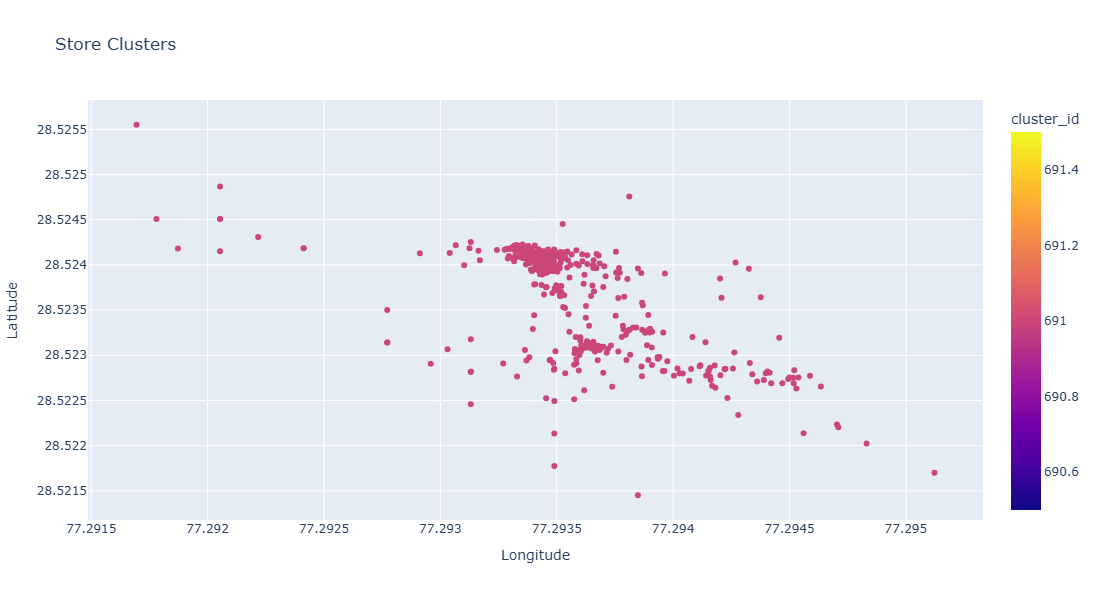

In [77]:
import plotly.express as px

# Subset the cluster
df1 = df[df['cluster_id']==691]

# Create an interactive scatter plot
fig = px.scatter(
    df1, 
    x='Longitude', 
    y='Latitude', 
    color='cluster_id', 
    hover_data=['StoreID','StoreName', 'State', 'Region','_cluster_outlier'],  # Columns to display on hover
    title="Store Clusters",
    labels={"Longitude": "Longitude", "Latitude": "Latitude"}
)

fig.update_layout(
    width=1000,  # Adjust width in pixels
    height=600   # Adjust height in pixels
)

# Show the interactive plot
fig.show()


In [ ]:
import matplotlib.pyplot as plt

# Separate outliers (-1) and valid clusters
df_outliers = df[df['cluster_id'] == -1]  # Outliers
df_clusters = df[df['cluster_id'] != -1]  # Valid clusters

plt.figure(figsize=(12, 6))

# Plot clustered points
plt.scatter(df_clusters['Longitude'], df_clusters['Latitude'], 
            c=df_clusters['cluster_id'], cmap='viridis', marker='o', label="Clusters")

# Plot outliers separately in red
plt.scatter(df_outliers['Longitude'], df_outliers['Latitude'], 
            c='red', marker='x', s=100, label="Outliers")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Store Clusters with Outliers')
plt.colorbar(label="Cluster ID")
plt.legend()
plt.show()
